In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [11]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge', 'train.csv', 'train.csv'))

In [12]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## 1. Prepocessing

### 1.1 Tokenization

In [8]:
from tensorflow.keras.layers import TextVectorization

In [13]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [14]:
MAX_FEATURES = 200000    # NUMBER OF WORDS IN THE VOCAB

In [15]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                              output_sequence_length=1800,
                              output_mode='int')

In [16]:
vectorizer.adapt(X.values)

In [10]:
vectorizer('Hello world!')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([288, 263,   0, ...,   0,   0,   0], dtype=int64)>

In [24]:
vectorized_text = vectorizer(X.values)

In [25]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

### 1.2 Creating tensorflow data pipeline

In [26]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [29]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [30]:
batch_X.shape

(16, 1800)

In [31]:
batch_y.shape

(16, 6)

In [16]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [17]:
len(test)

997

## 2. Create Sequential Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [21]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# Final layer
model.add(Dense(6, activation='sigmoid'))

In [22]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [25]:
history = model.fit(train, epochs=2, validation_data=val)

Epoch 1/2
6981/6981 [==============================] - 2878s 412ms/step - loss: 0.0598 - val_loss: 0.0447
Epoch 2/2
6981/6981 [==============================] - 2890s 414ms/step - loss: 0.0456 - val_loss: 0.0401


In [28]:
history.history

{'loss': [0.05983468517661095, 0.04557918384671211],
 'val_loss': [0.04471121355891228, 0.040117885917425156]}

In [29]:
import matplotlib.pyplot as plt

<Figure size 800x500 with 0 Axes>

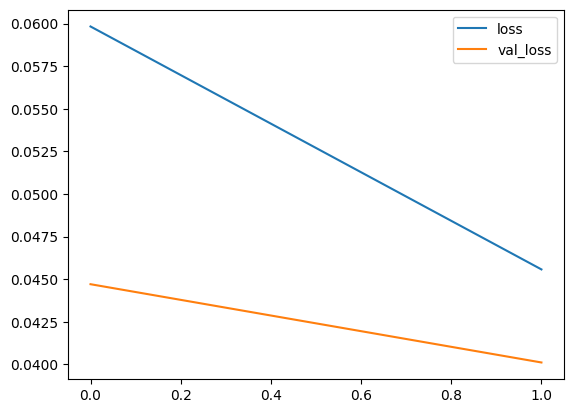

In [30]:
plt.figure(figsize=(8, 5))
pd.DataFrame(history.history).plot()
plt.show()

## 3. Make Predictions

In [31]:
input_text = vectorizer('You freaking suck! I am going to hurt you black scumbag.')

In [32]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0], dtype=int64)>

In [33]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [34]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 541ms/step


array([[0.9909389 , 0.21722957, 0.82464737, 0.09459402, 0.77440214,
        0.19538842]], dtype=float32)

In [35]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 57ms/step


In [36]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [37]:
test.as_numpy_iterator().next()

(array([[  248,   111,     4, ...,     0,     0,     0],
        [    4,   422,    38, ...,     0,     0,     0],
        [    1,    21,   621, ...,     0,     0,     0],
        ...,
        [    8,   324,    12, ...,     0,     0,     0],
        [21896, 11361,   121, ...,     0,     0,     0],
        [30801,   181,   211, ...,     0,     0,     0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

In [38]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 84ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

## 4. Evaluate Model

In [39]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [40]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [41]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 76ms/step


In [42]:
print(f'{pre.result()}, {re.result()}, {acc.result()}')

0.8677027821540833, 0.6667637825012207, 0.498495489358902


## 5. Test and Gradio

In [56]:
!pip install gradio jinja2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.7.1 which is incompatible.



  Obtaining dependency information for gradio from https://files.pythonhosted.org/packages/83/07/5040f8b58b91e8a1053f0148a7b515329a2dfc17d74e62cc0871a2b9908e/gradio-3.42.0-py3-none-any.whl.metadata
  Obtaining dependency information for aiofiles<24.0,>=22.0 from https://files.pythonhosted.org/packages/c5/19/5af6804c4cc0fed83f47bff6e413a98a36618e7d40185cd36e69737f3b0e/aiofiles-23.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for altair<6.0,>=4.2.0 from https://files.pythonhosted.org/packages/f2/b4/02a0221bd1da91f6e6acdf0525528db24b4b326a670a9048da474dfe0667/altair-5.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for fastapi from https://files.pythonhosted.org/packages/76/e5/ca411b260caa4e72f9ac5482f331fe74fd4eb5b97aa74d1d2806ccf07e2c/fastapi-0.103.1-py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for gradio-client==0.5.0 from https://fi

In [43]:
import gradio as gr

In [44]:
model.save('toxicity.h5')

C:\Users\kacpe\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
model = tf.keras.models.load_model('toxicity.h5')

In [17]:
input_str = vectorizer('hey I freaken hate you')

In [18]:
res = model.predict(np.expand_dims(input_str, 0))

1/1 [==============================] - 1s 546ms/step


In [19]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [20]:
(res > 0.5).astype(int)

array([[1, 0, 0, 0, 0, 0]])

In [51]:
def score_commment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [53]:
interface = gr.Interface(fn=score_commment,
                        inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

C:\Users\kacpe\AppData\Local\Temp\ipykernel_7632\3017201163.py:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
C:\Users\kacpe\AppData\Local\Temp\ipykernel_7632\3017201163.py:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
C:\Users\kacpe\AppData\Local\Temp\ipykernel_7632\3017201163.py:2: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),


In [55]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://53e2223a6a9104522e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 55ms/step
